# Notebook to generate a dataframe that for binned wbf and spike rate data

## Imports

In [7]:
import os 
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
from scipy import signal
from mosquito.process_abf import load_processed_data


## Helper functions

In [8]:
def bin_time_series(dat, keep_idx=None, bin_width=2*65536, groupby_func='mean'):
    """
    Function to bin data like wingbeat frequency or spike rate, as these are made 
    continuous by kernel convolution/overlapping short term fourier transform, and 
    are thus redundant at adjacent time points
    
    """
    # get bin edges, and bin indices for each dat value
    bin_edges = np.arange(0, dat.size, bin_width)
    bin_idx = np.digitize(np.arange(dat.size), bin_edges)

    # road splits depending on whether we want to keep all data (keep_idx=None)
    # or only some (keep_idx = flying_idx, for instance)
    if keep_idx is None:
        # use pandas to group data
        df = pd.DataFrame(data={'dat': dat, 'bin_idx': bin_idx })
    
        if groupby_func == 'mean':
            df_binned = df.groupby(['bin_idx']).mean()   
        elif groupby_func == 'median':
            df_binned = df.groupby(['bin_idx']).median()
        else:
            print('invalid grouping selection')
            return
    
        # read out binned data
        dat_binned = df_binned['dat'].values

    else:
        # use pandas to group data
        df = pd.DataFrame(data={'dat': dat, 'bin_idx': bin_idx, 'keep_idx': keep_idx })
    
        if groupby_func == 'mean':
            df_binned = df.groupby(['bin_idx', 'keep_idx'], as_index=False).mean()   
        elif groupby_func == 'median':
            df_binned = df.groupby(['bin_idx', 'keep_idx'], as_index=False).median()
        else:
            print('invalid grouping selection')
            return
    
        # read out binned data
        dat_binned = df_binned['dat'].loc[df_binned['keep_idx']].values


    return dat_binned
    

In [9]:
def get_corr(spike_rate, wbf, flying_idx, fs):
    """
    Calculate correlation coefficient between wbf and spike rate
    """
    # # read data
    # wbf = data['wbf']
    # spike_rate = data['spike_rate']
    # flying_idx = data['flying_idx']
    # fs = data['sampling_freq']
    
    #  z-score signals
    mode='same'
    sig1 = wbf[flying_idx]
    sig1 -= np.mean(sig1)
    sig1 /= np.std(sig1)
    sig2 = spike_rate[flying_idx]
    sig2 -= np.mean(sig2)
    sig2 /= np.std(sig2)

    # take cross corr
    corr = signal.correlate(sig1, sig2, mode=mode)
    lags = signal.correlation_lags(len(sig1), len(sig2), mode=mode)

    # get optimal shift
    time_series_shift = lags[np.argmax(corr)]
    time_series_shift_sec = time_series_shift/fs

    # get values that we care about
    # correlation without shift:
    R_noshift = np.corrcoef(spike_rate, wbf)[0,1]

    # correlation with shift:
    shifted_spike_rate = np.roll(spike_rate, time_series_shift)
    R_shift = np.corrcoef(shifted_spike_rate, wbf)[0,1]

    # do linear fit of shifted data
    slope, intercept = np.polyfit(wbf,  shifted_spike_rate, 1)
    
    # return values
    return R_shift, R_noshift, time_series_shift_sec, slope
    

## Params

In [10]:
# path to data
data_root = '/media/sam/SamData/Mosquitoes'

# species to look at?
species = 'aedes'

# where to save datraframe to 
save_flag = True
save_path = os.path.join(data_root, 'analysis')

# path to log file (and load)
log_path = os.path.join(data_root, 'experiment_log.xlsx')
log_df = pd.read_excel(log_path)


In [11]:
# list of data files to grab (given as (Expr number).(axo number))
bin_flag = False
data_files = ['19.1', '19.2', '19.4', '19.5', '19.6',
                  '22.0', '22.1', '22.2', '22.4', '22.5', '22.6', '22.7', '22.8', '22.9', '22.12',
                  '23.0', '23.1', '23.2', '23.3', '23.4', '23.5', '23.6', 
                  '24.7', '24.8', 
                  '26.1', '26.2', '26.3', 
                  '28.0', '28.1', '28.2', '28.5', '28.6', '28.8', '28.9', 
                  '29.7', '29.8',
                  '32.1',
                  '37.0', '37.1', '37.2', '37.3',
                  '38.8', '38.9', '38.10', '38.11', '38.14', '38.15'
    ]
   
data_files_ac_amp = ['15.1', '15.2', '15.3', '15.6', '15.8', '15.10',
                     '16.0', '16.1', 
                     '17.9'     
]


data_files_drosophila = ['18.0', '18.1', '27.5', '30.0', '30.1', '30.2', '31.3', '31.4', '31.5', '31.6',
                         '33.0', '33.1', '33.3', '33.4', '33.5', '34.1', '34.4', '34.5', '34.7', '35.0', 
                          '35.1', '36.0', '36.3', '36.4']

data_files += data_files_ac_amp
data_files += data_files_drosophila


## Make data frame for spike rate and wbf

In [12]:
# initialize storage for data
# start out with dictionary 
fly_dict = dict()

# intialize with some empty lists
fly_dict['expr_num'] = list()
fly_dict['axo_num'] = list()
fly_dict['muscle_target'] = list()
fly_dict['sex'] = list()
fly_dict['species'] = list()
fly_dict['fly_num'] = list()
fly_dict['electrode_num'] = list()

if bin_flag:
    fly_dict['spike_rate'] = list()
    fly_dict['wbf'] = list()
else:
    fly_dict['spike_rate_mean'] = list()
    fly_dict['wbf_mean'] = list()
    fly_dict['spike_rate_std'] = list()
    fly_dict['wbf_std'] = list()
    fly_dict['R'] = list()


# loop over data files
# get paths to experiment folders
expr_folders = sorted([f for f in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, f)) and f[:2].isdigit()])
expr_folder_inds = [f.split('_')[0] for f in expr_folders]
   
# turn data file numbers into paths
for file_str in data_files:
    # get experiment and axo number from data file number
    expr_num_str = file_str.split('.')[0]
    axo_num = int(file_str.split('.')[1])

    # get expr folder matching expr number
    expr_folder = expr_folders[expr_folder_inds.index(expr_num_str)]

    # get identifying info from log file
    row_idx = (log_df['Day'] == expr_folder) & (log_df['Axo Num'] == axo_num)
    muscle_target = log_df.loc[row_idx]['Target Muscle'].values[0]
    sex = log_df.loc[row_idx]['Sex'].values[0]
    species = log_df.loc[row_idx]['Species'].values[0]
    fly_num = log_df.loc[row_idx]['Fly Num'].values[0]
    electrode_num = log_df.loc[row_idx]['Electrode Num'].values[0]
    
    # load and read data
    data = load_processed_data(expr_folder, axo_num)
    wbf = data['wbf']
    spike_rate = data['spike_rate']
    flying_idx = data['flying_idx']
    fs = data['sampling_freq']
    
    # add to dictionary
    if bin_flag:
        # in case we want multiple time points per data
        wbf_binned = bin_time_series(wbf, keep_idx=flying_idx)
        spike_rate_binned = bin_time_series(spike_rate, keep_idx=flying_idx)
        
        fly_dict['expr_num'].extend([int(expr_num_str) for x in wbf_binned])
        fly_dict['axo_num'].extend([axo_num for x in wbf_binned])
        fly_dict['muscle_target'].extend([muscle_target for x in wbf_binned])
        fly_dict['sex'].extend([sex for x in wbf_binned])
        fly_dict['species'].extend([species for x in wbf_binned])
        fly_dict['fly_num'].extend([fly_num for x in wbf_binned])
        fly_dict['electrode_num'].extend([int(electrode_num) for x in wbf_binned])
        fly_dict['spike_rate'].extend(spike_rate_binned.tolist())
        fly_dict['wbf'].extend(wbf_binned.tolist())

    else:
        # in case we just want means
        wbf_mean = np.mean(wbf[flying_idx])
        wbf_std = np.std(wbf[flying_idx])
        spike_rate_mean = np.mean(spike_rate[flying_idx])
        spike_rate_std = np.std(spike_rate[flying_idx])
        
        fly_dict['expr_num'].append(int(expr_num_str))
        fly_dict['axo_num'].append(axo_num)
        fly_dict['muscle_target'].append(muscle_target)
        fly_dict['sex'].append(sex)
        fly_dict['species'].append(species)
        fly_dict['fly_num'].append(fly_num)
        fly_dict['electrode_num'].append(int(electrode_num))
        fly_dict['spike_rate_mean'].append(spike_rate_mean)
        fly_dict['spike_rate_std'].append(spike_rate_std)
        fly_dict['wbf_mean'].append(wbf_mean)
        fly_dict['wbf_std'].append(wbf_std)

        # also get correlation
        R, _, _, _ = get_corr(spike_rate, wbf, flying_idx, fs)
        fly_dict['R'].append(R)
        
    # print update
    print(f'completed {expr_folder}, {axo_num}')
    
# convert to pandas data frame
fly_df = pd.DataFrame.from_dict(fly_dict)
fly_df

completed 19_20240510, 1
completed 19_20240510, 2
completed 19_20240510, 4
completed 19_20240510, 5
completed 19_20240510, 6
completed 22_20240516, 0
completed 22_20240516, 1
completed 22_20240516, 2
completed 22_20240516, 4
completed 22_20240516, 5
completed 22_20240516, 6
completed 22_20240516, 7
completed 22_20240516, 8
completed 22_20240516, 9
completed 22_20240516, 12
completed 23_20240517, 0
completed 23_20240517, 1
completed 23_20240517, 2
completed 23_20240517, 3
completed 23_20240517, 4
completed 23_20240517, 5
completed 23_20240517, 6
completed 24_20240520, 7
completed 24_20240520, 8
completed 26_20240524, 1
completed 26_20240524, 2
completed 26_20240524, 3
completed 28_20240529, 0
completed 28_20240529, 1
completed 28_20240529, 2
completed 28_20240529, 5
completed 28_20240529, 6
completed 28_20240529, 8
completed 28_20240529, 9
completed 29_20240530, 7
completed 29_20240530, 8
completed 32_20240625, 1
completed 37_20240708, 0
completed 37_20240708, 1
completed 37_20240708, 2

,expr_num,axo_num,muscle_target,sex,species,fly_num,electrode_num,spike_rate_mean,wbf_mean,spike_rate_std,wbf_std,R
0,19,1,DVM,F,Aedes,1,2,2.046725,402.653238,0.112180,2.571270,0.426289
1,19,2,DLM,F,Aedes,1,3,1.666345,396.809104,0.120162,3.119173,0.401325
2,19,4,DVM,F,Aedes,2,2,2.015044,333.719897,0.358149,23.506436,0.640120
3,19,5,DVM,F,Aedes,3,1,2.245844,484.246798,0.335116,11.927822,0.650959
4,19,6,DLM,F,Aedes,3,2,1.208944,449.522630,0.188145,9.815178,0.742476
...,...,...,...,...,...,...,...,...,...,...,...,...
75,35,0,DLM,F,Drosophila,1,1,7.097113,167.986968,0.839368,2.988863,0.362961
76,35,1,DLM,F,Drosophila,2,1,3.588426,173.472828,0.718985,2.008533,0.254030
77,36,0,DVM,F,Drosophila,1,1,10.496920,169.775489,1.919402,0.978979,0.288086
78,36,3,DLM,F,Drosophila,2,3,6.654388,153.836237,0.846825,0.993213,0.206836


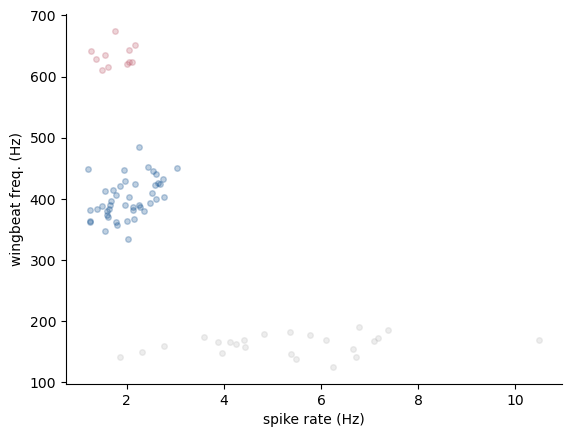

In [13]:
# quick plot
fig, ax = plt.subplots()
# colors for species
colors = ['#004488', '#BB5566', '#BBBBBB']
species_list = ['Aedes', 'Aedes', 'Drosophila']
sex_list = ['F', 'M', 'F']

# loop over species and sex
for ith, (spec, sx) in enumerate(zip(species_list, sex_list)):
    # get index matching current dataset
    idx = (fly_df['species'] == spec) & (fly_df['sex'] == sx)
    
    # get data
    if bin_flag:
        x = fly_df['spike_rate'][idx]
        y = fly_df['wbf'][idx]
    else:
        x = fly_df['spike_rate_mean'][idx]
        y = fly_df['wbf_mean'][idx]

    # plot
    ax.plot(x, y, '.', ms=8, alpha=0.25, color=colors[ith])

# label axes
ax.set_xlabel('spike rate (Hz)')
ax.set_ylabel('wingbeat freq. (Hz)')

# axis spines
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)


In [14]:
# save fly data 
if save_flag:
    if bin_flag:
        fly_df.to_pickle(os.path.join(save_path, 'spike_rate_wbf_data_binned.pkl'))
    else:
        fly_df.to_pickle(os.path.join(save_path, 'spike_rate_wbf_data.pkl'))
        fly_df.to_excel(os.path.join(save_path, 'spike_rate_wbf_data.xlsx'))